In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np

from utils import OUR_NAME
from sky_spot import utils
from plot import *

sns.set_style('whitegrid')

InitMatplotlib(7, 7)


use_tex True 
font_size 7 
title_size 7


In [9]:
import utils

# EXP_PATH = '../../exp-for-plot/real/ddl=search+task=48+overhead=0.20/real'
EXP_PATH = '../../exp-for-plot/real/2023-02-15/ddl=search+task=48+overhead=0.20/real'
df = utils.get_dfs_from_exp(EXP_PATH)
df['deadline_ratio'] = df['deadline_hours'] / df['task_hours']
df

/home/gcpuser/skypilot-spot-strategy/scripts/plots/utils.py:48: RuntimeWarning: Mean of empty slice.
  avg_wait_hours = get_consecutive_1s(
/opt/conda/envs/sky-spot/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gcpuser/skypilot-spot-strategy/scripts/plots/utils.py:47: RuntimeWarning: Mean of empty slice.
  avg_spot_hours = spot_hours.mean()


,trace,env,strategy,deadline_hours,task_hours,task_fraction,gap_seconds,avg_spot_hours,avg_wait_hours,num_slices,spot_fraction,cost,deadline_ratio
0,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-west-2a_v100_1,time_sliced_by_num,56.0,48.0,0.857143,195,8.946528,0.465833,5.0,0.958557,47.807592,1.166667
1,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-west-2a_v100_1,time_sliced_by_num,56.0,48.0,0.857143,195,9.360000,2.302083,5.0,0.835714,76.512237,1.166667
2,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-west-2a_v100_1,time_sliced_by_num,56.0,48.0,0.857143,195,8.946528,0.465833,5.0,0.958557,47.491335,1.166667
3,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-west-2a_v100_1,time_sliced_by_num,56.0,48.0,0.857143,195,2.267778,1.570833,5.0,0.607440,109.866142,1.166667
4,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-west-2a_v100_1,time_sliced_by_num,56.0,48.0,0.857143,195,13.744792,0.343056,5.0,0.981771,47.491335,1.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067995,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-east-2b_v100_1,time_sliced_by_num,64.0,48.0,0.750000,195,2.918229,1.155556,34.0,0.729557,74.151074,1.333333
1067996,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-east-2b_v100_1,time_sliced_by_num,64.0,48.0,0.750000,195,7.407292,0.680952,34.0,0.925911,50.105867,1.333333
1067997,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-east-2b_v100_1,time_sliced_by_num,64.0,48.0,0.750000,195,4.875000,3.128125,34.0,0.609375,84.566674,1.333333
1067998,../../exp-for-plot/real/2023-02-15/ddl=search+...,us-east-2b_v100_1,time_sliced_by_num,64.0,48.0,0.750000,195,3.732083,2.427652,34.0,0.583138,101.823112,1.333333


In [10]:
print('spot low:', sum(df['spot_fraction'] < 0.5) / len(df))
print('spot high:', sum(df['spot_fraction'] >= 0.5) / len(df))

spot low: 0.2779054307116105
spot high: 0.7220945692883896


In [11]:
# new_df = df[df['trace'].str.contains('us-west-2b_v100_1')].copy()
new_df = df.copy()

GAP_TO_OPTIMAL = True
# GAP_TO_OPTIMAL = False

optimal_strategy = 'ideal_ilp_overhead'
if '2023' in EXP_PATH:
    optimal_strategy = 'quick_optimal'

print(optimal_strategy)

def normalize_cost(x):
    x = x.copy()
    optimal_row = x[x['strategy'] == optimal_strategy]
    if optimal_row.empty:
        assert x['deadline_hours'].iloc[0] == 92, x
        return None
    optimal_cost = x[x['strategy'] == optimal_strategy]['cost'].values[0]
    on_demand_cost = x[x['strategy'] == 'on_demand']['cost'].values[0]
    if GAP_TO_OPTIMAL:
        non_optimal_costs = x[~x['strategy'].isin(
            ['quick_optimal', 'ideal_ilp_overhead', 'rc_next_spot_threshold'])]
        assert non_optimal_costs['cost'].min() >= optimal_cost - 1, (non_optimal_costs.loc[non_optimal_costs['cost'].idxmin()], optimal_cost, non_optimal_costs['cost'].min() - optimal_cost)
    
        # x['saving'] = np.clip(x['cost'] - optimal_cost, 0, None) / optimal_cost * 100
        x['saving'] = np.clip(x['cost'] - optimal_cost, 0, None) / on_demand_cost * 100
    else:
        x['saving'] = (1 - x['cost'] / on_demand_cost) * 100
    return x


new_df = new_df.groupby(['trace', 'task_fraction']).apply(normalize_cost)




quick_optimal


In [12]:
greedy_df = new_df[new_df['strategy'] == 'strawman']
# ours_df = new_df[new_df['strategy'] == 'rc_v2dt_threshold']
ours_df = new_df[new_df['strategy'] == 'rc_cr_threshold']
ours_next_spot_df = new_df[new_df['strategy'] == 'rc_next_spot_threshold']
optimal_df = new_df[new_df['strategy'] == 'ideal_ilp_overhead']
time_sliced_df = new_df[(new_df['strategy'] == 'time_sliced_by_num') & (new_df['num_slices'] == 4)]
knowing_next_spot_df = new_df[new_df['strategy'] == 'rc_next_spot_threshold']

{'Greedy': array([[10.26548986, 10.03443811],
       [ 5.42788129, 13.3641372 ]]), 'Time Sliced (Best \\#slices)': array([[ 9.32397673,  9.73397772],
       [ 5.97789046, 10.59017621]]), 'Uniform Progress (Ours)': array([[5.1307071 , 6.1933164 ],
       [4.00584685, 7.15279964]]), 'Uniform Progress (w. next spot oracle)': array([[2.88426301, 1.80234905],
       [3.09656096, 2.49467005]])}
date: -2months


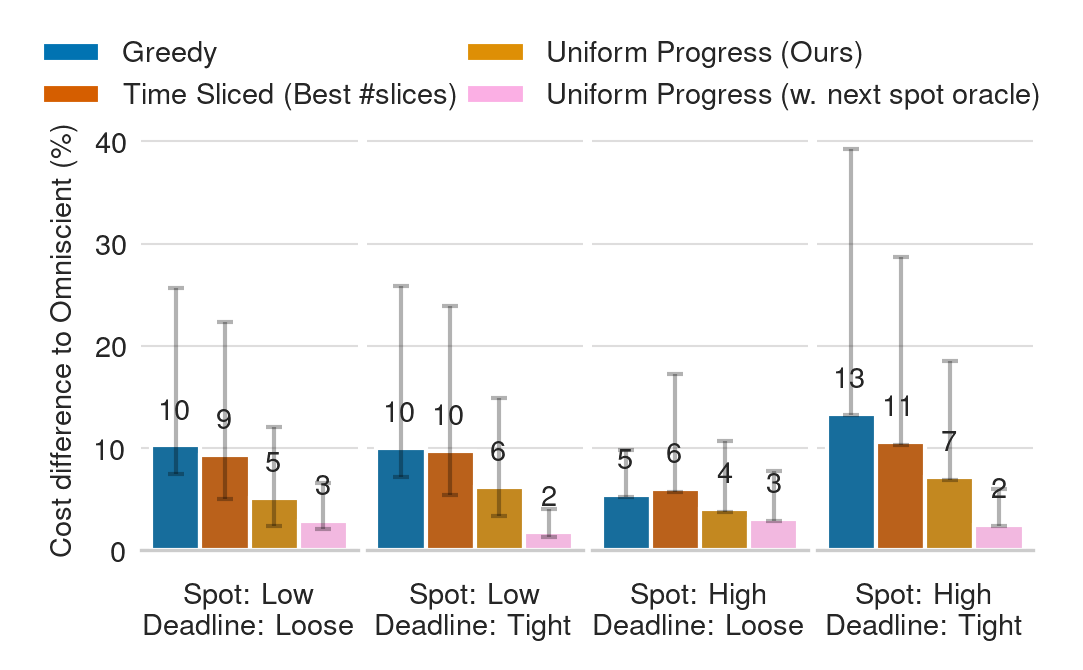

In [13]:
def get_task_category(df):
    low_task_fraction = df[(df['task_fraction'] < 0.75)
                           & (df['task_fraction'] > 0.6)]
    high_task_fraction = df[df['task_fraction'] >= 0.75]
    return low_task_fraction, high_task_fraction


def get_spot_category(df):
    low_spot_fraction = df[df['spot_fraction'] < 0.5]
    high_spot_fraction = df[df['spot_fraction'] >= 0.5]

    return low_spot_fraction, high_spot_fraction


# def get_task_category(df):
#     low_task_fraction = df[df['task_fraction'] < 0.7]
#     medium_task_fraction = df[(df['task_fraction'] >= 0.7) & (df['task_fraction'] < 0.85)]
#     high_task_fraction = df[df['task_fraction'] >= 0.85]
#     return low_task_fraction, medium_task_fraction, high_task_fraction

# def get_spot_category(df):
#     low_spot_fraction = df[df['spot_fraction'] < 0.333]
#     medium_spot_fraction = df[(df['spot_fraction'] >= 0.333) & (df['spot_fraction'] < 0.6666)]
#     high_spot_fraction = df[df['spot_fraction'] >= 0.6666]

#     return low_spot_fraction, medium_spot_fraction, high_spot_fraction


# task fraction  low medium  high
# spot fraction
# low
# medium
# high
def get_nxn(df):
    matrix = get_spot_category(df)
    matrix = [get_task_category(m) for m in matrix]
    cost_matrix = np.zeros((len(matrix), len(matrix[0])))
    std_matrix = np.zeros((len(matrix), len(matrix[0])))
    p25_matrix = np.zeros((len(matrix), len(matrix[0])))
    p75_matrix = np.zeros((len(matrix), len(matrix[0])))
    for i, row in enumerate(matrix):
        for j, col in enumerate(row):
            cost_matrix[i, j] = col['saving'].mean()
            std_matrix[i, j] = col['saving'].std()
            p25_matrix[i, j] = np.percentile(col['saving'], 25)
            p75_matrix[i, j] = np.percentile(col['saving'], 75)
    return cost_matrix, std_matrix, p25_matrix, p75_matrix

def empty_nxn(df):
    matrix = get_spot_category(df)
    matrix = [get_task_category(m) for m in matrix]
    cost_matrix = np.zeros((len(matrix), len(matrix[0])))
    std_matrix = np.zeros((len(matrix), len(matrix[0])))
    p25_matrix = np.zeros((len(matrix), len(matrix[0])))
    p75_matrix = np.zeros((len(matrix), len(matrix[0])))
    return cost_matrix, std_matrix, p25_matrix, p75_matrix

cost_matrices = {}
std_matrices = {}
p25_matrices = {}
p75_matrices = {}

cost_matrices['Greedy'], std_matrices['Greedy'], p25_matrices['Greedy'], p75_matrices['Greedy'] = get_nxn(greedy_df)
if not time_sliced_df.empty:
    cost_matrices['Time Sliced (Best \#slices)'], std_matrices[
        'Time Sliced (Best \#slices)'], p25_matrices[
            'Time Sliced (Best \#slices)'], p75_matrices[
                'Time Sliced (Best \#slices)'] = get_nxn(time_sliced_df)
cost_matrices[f'{OUR_NAME} (Ours)'], std_matrices[f'{OUR_NAME} (Ours)'], p25_matrices[f'{OUR_NAME} (Ours)'], p75_matrices[f'{OUR_NAME} (Ours)'] = get_nxn(ours_df)
cost_matrices[f'{OUR_NAME} (w. next spot oracle)'], std_matrices[
    f'{OUR_NAME} (w. next spot oracle)'], p25_matrices[
        f'{OUR_NAME} (w. next spot oracle)'], p75_matrices[
            f'{OUR_NAME} (w. next spot oracle)'] = get_nxn(
                knowing_next_spot_df)
# empty_nxn(ours_next_spot_df)
#

# cost_matrices[f'{OUR_NAME}\n(+spot)'], std_matrices['ours_next_spot'] = get_nxn(ours_next_spot_df)
if not GAP_TO_OPTIMAL:
    cost_matrices['Optimal'], std_matrices['Optimal'], p25_matrices['Optimal'], p75_matrices['Optimal'] = get_nxn(optimal_df)



print(cost_matrices)

if len(cost_matrices['Greedy'][0]) == 2:
    spot_values = ['Low', 'High']
    task_values = ['Loose', 'Tight']
else:
    spot_values = ['low', 'med', 'high']
    task_values = ['low', 'med', 'high']

fig = plt.figure(figsize=(fig_width, fig_height - .3), dpi=300)

# # Add percentage for spot fractions
# percentage_ax = fig.add_subplot(111, frameon=False)
# # Set x-axis limit
# percentage_ax.set_xlim(0, 100)
# percentage_ax.set_ylim(0, 1)

# # Draw a line at y = 0 from x = 0 to x = 28, color it red
# # ax.axhline(0, xmin=0, xmax=0.28, color=palette[2], linewidth=5)

# # Draw a line at y = 0 from x = 28 to x = 100, color it blue
# # ax.axhline(0, xmin=0.28, xmax=1, color=palette[3], linewidth=5)

# # Annotate percentages
# percentage_ax.fill_betweenx([0, 1], 0, 50, color=palette[1], alpha=0.05, edgecolor=None)
# percentage_ax.fill_betweenx([0, 1], 50, 100, color=palette[0], alpha=0.05, edgecolor=None)

# spot_low = sum(df['spot_fraction'] < 0.5) / len(df)
# spot_high = sum(df['spot_fraction'] >= 0.5) / len(df)

# # Remove y-ticks
# percentage_ax.yaxis.set_visible(False)
# percentage_ax.xaxis.set_visible(False)

axes = fig.subplots(1, len(task_values) * len(spot_values),
                    sharex=True,
                    sharey=True,
                    # squeeze=True,
                    )
palette = sns.color_palette("colorblind", n_colors=10)
if len(cost_matrices) == 3:
    palette = [palette[0], palette[1], palette[6]]

if len(cost_matrices) == 4:
    palette = [palette[0], palette[3], palette[1], palette[6]]
# strategies = ['Greedy', f'{OUR_NAME} (Ours)', 'Optimal']

def add_bar_annotations(ax, errors=None, value_precision=0, error_precision=1):
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        error_value = ''
        if error_precision is not None:
            error_value = f" ± {errors[i]:.{error_precision}f}" if errors is not None else ""
        annotation = f"{height:.{value_precision}f}{error_value}"
        ax.annotate(
            annotation,
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            xytext=(0, 5),
            textcoords="offset points",
        )


for i, s in enumerate(spot_values):
    for j, t in enumerate(task_values):
        ax = axes[i*len(spot_values) + j]
        ax.set_facecolor('none')
        ax.set_ylabel('Saving')
        means = [cost_matrices[strategy][i, j] for strategy in cost_matrices.keys()]
        stds = [std_matrices[strategy][i, j] for strategy in cost_matrices.keys()]
        p25 = [p25_matrices[strategy][i, j] for strategy in cost_matrices.keys()]
        p75 = [
            p75_matrices[strategy][i, j] for strategy in cost_matrices.keys()
        ]
        strategies = list(cost_matrices.keys())
        sns.barplot(x=strategies, y=means, ax=ax, palette=palette, width=1)
        if GAP_TO_OPTIMAL:
            ax.errorbar(x=strategies, y=means, yerr=np.vstack([p25, p75]), fmt='none', ecolor='black', capsize=2, alpha=0.3)
        else:
            ax.errorbar(x=strategies, y=means, yerr=np.vstack([p25, p75]), fmt='none', ecolor='black', capsize=2, alpha=.3)
            # ax.errorbar(x=strategies, y=means, yerr=stds, fmt='none', ecolor='black', capsize=2)
        # ax.hlines(1-1/utils.COST_K, -0.5, 2.5, colors='black', linestyles='dotted', alpha=.5, label='Upper Bound')
        # ax.set_ylim(0, 75)
        ax.set_xticklabels([''] * len(strategies))
        ax.set_xlabel(f'Spot: {s}\nDeadline: {t}')
        ax.set_ylabel('')
        # ax.set_xticklabels(['', '', ''])
        add_bar_annotations(ax, stds, value_precision=0, error_precision=None)

ax = axes[0]
if GAP_TO_OPTIMAL:
    ax.set_ylabel('Cost difference to Omniscient (\%)')
else:
    ax.set_ylabel('Cost Savings (\%)')


# Create custom legend elements
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=palette[i], edgecolor=None, label=strategies[i])
    for i in range(len(strategies))
]

date_str = ''
if '2023' in EXP_PATH:
    date_str = '-2months'
    fig.legend(handles=legend_elements,
               title='',
               loc='upper center',
               ncol=2,
               columnspacing=.3,
               bbox_to_anchor=(0.5, 1.2))
else:
    # # Add the global legend
    fig.legend(handles=legend_elements,
               title='',
               loc='upper center',
               ncol=2,
               columnspacing=.3,
               bbox_to_anchor=(0.5, 1.2))


# percentage_ax.text(25, 0.8, f'{spot_low * 100:.0f}\\%', ha='center', va='center', fontsize=10)
# percentage_ax.text(75, 0.8, f'{spot_high * 100:.0f}\\%', ha='center', va='center', fontsize=10)

fig.tight_layout(pad=.3)
if GAP_TO_OPTIMAL:
    print('date:', date_str)
    fig.savefig(f'figures/savings_gap_to_optimal{date_str}.pdf', bbox_inches='tight', pad_inches=0)
else:
    fig.savefig(f'figures/savings{date_str}.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()

In [14]:
result = []
for i, s in enumerate(spot_values):
    for j, t in enumerate(task_values):
        ax = axes[i, j]
        category_name = f'{s} spot, {t} task'
        for strategy in cost_matrices.keys():
            result.append({
                'category': category_name,
                'strategy': strategy,
                'cost': cost_matrices[strategy][i, j],
                'p25': p25_matrices[strategy][i, j],
                'p75': p75_matrices[strategy][i, j]
            })
barplot_df = pd.DataFrame(result)

barplot_df['strategy'] = pd.Categorical(barplot_df['strategy'], categories=['Greedy', 'Ours', 'Optimal'])
barplot_df['category'] = pd.Categorical(barplot_df['category'], categories=['High spot, High task', 'Low spot, Low task', 'Low spot, High task', 'High spot, Low task'])

barplot_df = barplot_df.sort_values(['category',
                                     'strategy']).reset_index(drop=True)
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.subplots()
bar_plot = sns.barplot(data=barplot_df,
            x='category',
            y='cost',
            hue='strategy',
            palette=palette,
            ax=ax)

# Calculate x positions considering the grouping of 'category' and 'strategy'
x_pos = []
num_strategies = len(barplot_df['strategy'].unique())
for i, patch in enumerate(bar_plot.patches):
    if i % num_strategies == 0:
        x_pos.append([])
    x_pos[-1].append(patch.get_x() + patch.get_width() / 2)

# Flatten the grouped x positions
x_pos_flat = [item for sublist in x_pos for item in sublist]

ax.errorbar(x=x_pos_flat,
            y=barplot_df['cost'],
            yerr=([barplot_df['p25'], barplot_df['p75']]),
            fmt='none',
            ecolor='black',
            capsize=2,
            alpha=0.3)

ax.set_xlabel('')
# rotate the x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(20)
    tick.set_ha('center')
if GAP_TO_OPTIMAL:
    ax.set_ylabel('Percentage gap to optimal (\%)')
else:
    ax.set_ylabel('Cost Savings (\%)')

for i, patch in enumerate(bar_plot.patches):
    ax.annotate(f"{barplot_df['cost'].iloc[i]:.0f}",
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center',
                va='baseline',
                fontsize=8,
                color='black',
                rotation=0,
                xytext=(0, 3),
                textcoords='offset points')
fig.tight_layout()
if GAP_TO_OPTIMAL:
    fig.savefig('figures/gap_to_optimal_1plot.pdf', bbox_inches='tight')
else:
    fig.savefig('figures/savings_1plot.pdf', bbox_inches='tight')


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Get std cost for each strategy
result_path = os.path.dirname(exp_path.replace('exp-for-plot', 'results-plot'))
for file in os.listdir(result_path):
    env = file.replace('.csv', '')
    agg_result_df = pd.read_csv(os.path.join(result_path, file))
    std_df = df.loc[df['env'] == env, ['strategy', 'deadline_hours', 'cost']].groupby(['strategy',  'deadline_hours']).std().reset_index().rename(columns={'cost': 'std_cost'})
    mean_df = df.loc[df['env'] == env, ['strategy', 'deadline_hours', 'cost']].groupby(['strategy',  'deadline_hours']).mean().reset_index().rename(columns={'cost': 'cost_mean'})
    print(std_df)
    agg_result_df = pd.merge(agg_result_df, std_df, on=['strategy', 'deadline_hours'], how='left')
    test_mean = pd.merge(agg_result_df, mean_df, on=['strategy', 'deadline_hours'], how='left')
    agg_result_df.to_csv(os.path.join(result_path, f'{env}.csv'), index=False)


              strategy  deadline_hours   std_cost
0   ideal_ilp_overhead            52.0  17.006140
1   ideal_ilp_overhead            56.0  19.186511
2   ideal_ilp_overhead            60.0  19.601862
3   ideal_ilp_overhead            64.0  19.765032
4   ideal_ilp_overhead            68.0  20.246340
..                 ...             ...        ...
83            strawman            76.0  32.136404
84            strawman            80.0  31.706997
85            strawman            84.0  31.871248
86            strawman            88.0  30.051612
87            strawman            92.0  28.763499

[88 rows x 3 columns]


/tmp/ipykernel_3887/2775465893.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'std_cost_x'} in the result is deprecated and will raise a MergeError in a future version.
  agg_result_df = pd.merge(agg_result_df, std_df, on=['strategy', 'deadline_hours'], how='left')


IsADirectoryError: [Errno 21] Is a directory: '../../results-plot/real/ddl=search+task=48+overhead=0.20/ddl=search+task=48+overhead=0.20'

/tmp/ipykernel_16042/1171268813.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (greedy_cost - optimal_cost) / (strategy_cost - optimal_cost)
/tmp/ipykernel_16042/1171268813.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return (greedy_cost - optimal_cost) / (strategy_cost - optimal_cost)


                                                                                                                     trace  \
trace                                              task_fraction                                                             
../../exp-for-plot/real/2023-02-15/ddl=search+t... 0.545455      139500  ../../exp-for-plot/real/2023-02-15/ddl=search+...   
                                                   0.571429      151800  ../../exp-for-plot/real/2023-02-15/ddl=search+...   
                                                   0.600000      150900  ../../exp-for-plot/real/2023-02-15/ddl=search+...   
                                                   0.631579      152700  ../../exp-for-plot/real/2023-02-15/ddl=search+...   
                                                   0.666667      146100  ../../exp-for-plot/real/2023-02-15/ddl=search+...   
...                                                                                                                   

/opt/conda/envs/sky-spot/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


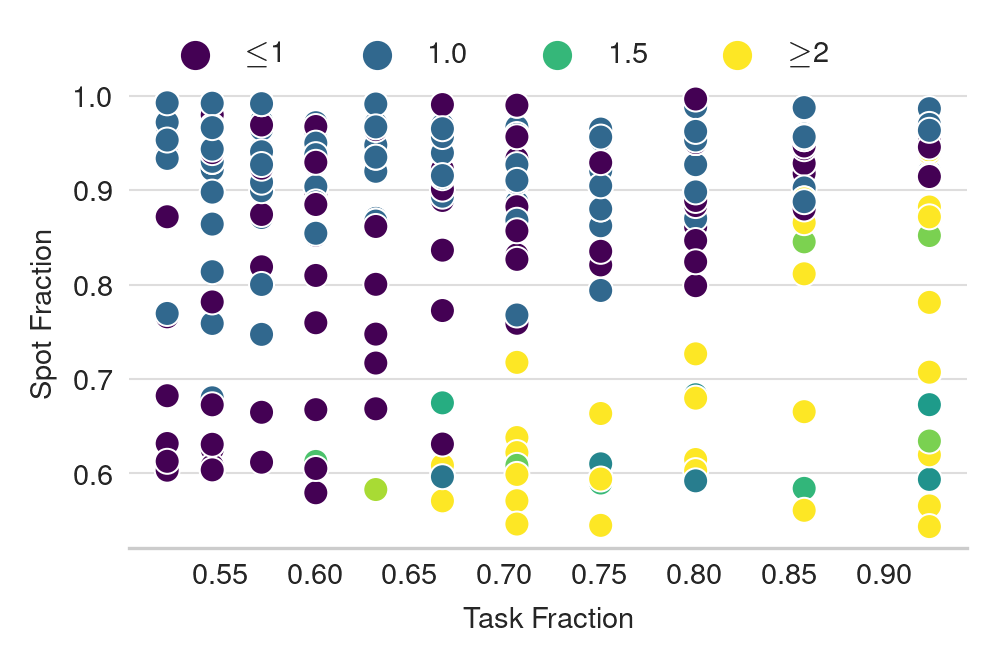

In [ ]:
from matplotlib.colors import Normalize

strategy1 = 'rc_v2dt_threshold'
strategy2 = 'strawman'

result_df = df
# result_df = result_df[result_df['strategy'].isin([strategy1, strategy2, 'on_demand'])]

def optimal_gap_ratio(greedy_cost, strategy_cost, optimal_cost):
    return (greedy_cost - optimal_cost) / (strategy_cost - optimal_cost)

def compare_cost(x):
    result_row = x[x['strategy'] == strategy1].copy()
    strategy_cost = x[x['strategy'] == strategy1]['cost']
    greedy_cost = x[x['strategy'] == strategy2]['cost']
    optimal_cost = x[x['strategy'] == 'quick_optimal']['cost']
    if any(c.empty for c in [strategy_cost, greedy_cost, optimal_cost]):
        return None
    result_row['cost'] = optimal_gap_ratio(
        greedy_cost.values[0], strategy_cost.values[0], optimal_cost.values[0])
    return result_row
result_df = result_df.groupby(['trace', 'task_fraction']).apply(compare_cost)
print(result_df)


fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.subplots()
sampled = result_df[result_df['trace'].str.contains('us-west-2b_v100_1')].copy()
# sampled = result_df.copy()
sampled = sampled.sample(n=500, random_state=44)
color_group = []
for a in sampled['cost']:
    if a < 1:
        color_group.append(0.5)
    elif a > 2:
        color_group.append(2.)
    else:
        color_group.append(a)
sampled['color_group'] = color_group
# sampled = sampled[~np.isclose(sampled['cost'], 1)]
# sampled = sampled[sampled['task_fraction'] > 0.6]
sns.scatterplot(
    data=sampled,
    x='task_fraction',
    y='spot_fraction',
    hue='color_group',
    # size='cost',
    vmax=4,
    ax=ax,
    legend='auto',
    palette='viridis',
    norm=Normalize(vmin=0, vmax=4),
)
ax.set_xlabel('Task Fraction')
ax.set_ylabel('Spot Fraction')
ax.legend().set_visible(False)

handles, labels = ax.get_legend_handles_labels()
custom_labels = [f'$\le$1', '1.0', '1.5', '$\ge$2']
handles_labels = list(zip(handles[::2], custom_labels))

legend = fig.legend(*zip(*handles_labels), title='',
           loc='upper center',
           ncol=4,
           bbox_to_anchor=(0.5, 1.05),
           )
# legend.get_frame().set_edgecolor('black')
fig.tight_layout()
fig.savefig('figures/perfomance_gain.pdf', bbox_inches='tight')

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
scatter_df = df.copy()
# scatter_df = df[df['trace'].str.contains('us-west-2b_v100_1')].copy()

def normalize_cost(x):
    x = x.copy()
    x['saving'] = 1 - x['cost'] / x[x['strategy'] ==
                                    'on_demand']['cost'].values[0]
    return x


scatter_df = scatter_df.groupby(['trace', 'task_fraction']).apply(normalize_cost)




/tmp/ipykernel_7418/24528429.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  scatter_df = scatter_df.groupby(['trace', 'task_fraction']).apply(normalize_cost)


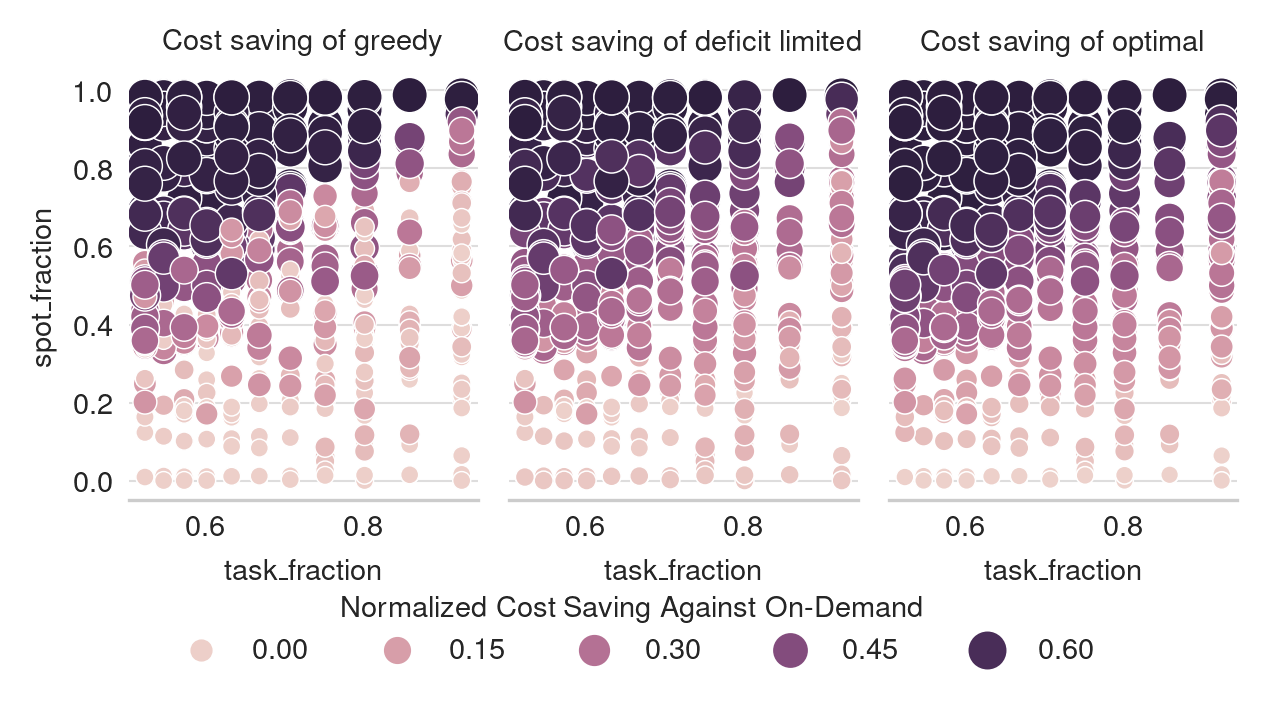

In [ ]:
unique_groups = scatter_df[['trace', 'task_fraction']].drop_duplicates()
sampled_groups = unique_groups.sample(n=500, random_state=44)
sampled_df = pd.merge(scatter_df,
                      sampled_groups,
                      on=['trace', 'task_fraction'],
                      how='inner')
def plot_strategy_scatter(strategy, ax):

    sns.scatterplot(
        data=sampled_df[sampled_df['strategy'] == strategy],
        x='task_fraction',
        y='spot_fraction',
        hue='saving',
        size='saving',
        s=100,
        ax=ax,
        legend='auto',
    )
    ax.legend().set_visible(False)
    strategy_name = strategy.replace('strawman', 'greedy')
    strategy_name = strategy_name.replace('rc_v2dt_threshold', 'deficit limited')
    strategy_name = strategy_name.replace('quick_optimal', 'optimal')
    ax.set_title(f'Cost saving of {strategy_name}')

#     fig.savefig('figures/real_strategies.pdf', bbox_inches='tight')
fig = plt.figure(figsize=(fig_width+.9, fig_height), dpi=300)
axes = fig.subplots(1, 3, sharex=True, sharey=True)
plot_strategy_scatter('strawman', axes[0])
plot_strategy_scatter('rc_v2dt_threshold', axes[1])
plot_strategy_scatter('quick_optimal', axes[2])
fig.legend(title='Normalized Cost Saving Against On-Demand',
        loc='lower center',
        ncol=5,
        handles=axes[0].get_legend_handles_labels()[0],
        bbox_to_anchor=(0.5, -0.12))
fig.tight_layout()

In [ ]:
def plot_strategy_heatmap(strategy):
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
    ax = fig.subplots()
    result_df = df[df['strategy'] == strategy][['task_fraction', 'spot_fraction', 'cost']]
    # result_df = result_df.sample(frac=0.01, random_state=42)
    # agg_df = result_df.groupby(['task_fraction', 'spot_fraction']).mean().reset_index()
    # pivot_df = agg_df.pivot('task_fraction', 'spot_fraction', 'cost')
    # cross_tab = pd.crosstab(index=result_df['task_fraction'], columns=result_df['spot_fraction'], values=result_df['cost'], aggfunc='mean')
    sns.kdeplot(x=result_df['task_fraction'], y=result_df['spot_fraction'], weights=result_df['cost'], cmap='coolwarm', ax=ax, shade=True, cbar=True)
#     ax.legend().set_visible(False)

#     fig.legend(title='Improvement against greedy',
#             loc='upper center',
#             ncol=5,
#             handles=ax.get_legend_handles_labels()[0],
#             bbox_to_anchor=(0.5, 1.2))
# fig.tight_layout()
#     fig.savefig('figures/heat_map.pdf', bbox_inches='tight')

In [ ]:
plot_strategy_heatmap('strawman')

/tmp/ipykernel_3456/3823658733.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=result_df['task_fraction'], y=result_df['spot_fraction'], weights=result_df['cost'], cmap='coolwarm', ax=ax, shade=True, cbar=True)


/tmp/ipykernel_3456/3823658733.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=result_df['task_fraction'], y=result_df['spot_fraction'], weights=result_df['cost'], cmap='coolwarm', ax=ax, shade=True, cbar=True)


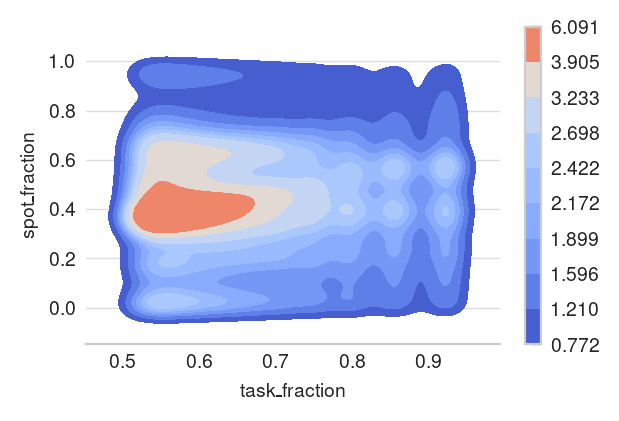

In [ ]:
plot_strategy_heatmap('rc_v2dt_threshold')


/tmp/ipykernel_7869/3428919111.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (greedy_cost - optimal_cost) / (strategy_cost - optimal_cost)
/tmp/ipykernel_7869/3428919111.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return (greedy_cost - optimal_cost) / (strategy_cost - optimal_cost)


                                                                                                                    trace  \
trace                                              task_fraction                                                            
../../exp-for-plot/exp-for-plot/real/ddl=search... 0.521739      30000  ../../exp-for-plot/exp-for-plot/real/ddl=searc...   
                                                   0.545455      18000  ../../exp-for-plot/exp-for-plot/real/ddl=searc...   
                                                   0.571429      28800  ../../exp-for-plot/exp-for-plot/real/ddl=searc...   
                                                   0.600000      28200  ../../exp-for-plot/exp-for-plot/real/ddl=searc...   
                                                   0.631579      29700  ../../exp-for-plot/exp-for-plot/real/ddl=searc...   
...                                                                                                                   ...   
